# Cover Letter Generator

In today's competitive job market, submitting your resume often just isn't enough to make you stand out. Many companies now require a cover letter, but when you are applying to several jobs at once, writing an individual cover letter for each position can be time consuming. This project will solve this problem by creating a cover letter generator. 

The original goal was to use user information about the job listing and their experience extracted from a resume to create a unique cover letter for each job. Due to lack of training data, this generator can only generate generic cover letters with tokens that the user can fill in themselves.

Further work on this project is needed to accomplish the original goal, specifically more training data (sample cover letters) are needed. Despite not accomplishing the original goal, this model could still be useful by giving the user a starting point when writing cover letters if more training data was obtained.

In [1]:
#!pip install tensorflow
#!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk import word_tokenize

from transformers import BertTokenizer, TFBertModel, BertConfig

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import matplotlib.pyplot as plt

First I will define a function to checkout some of the corpus statistics.

In [3]:
def corpus_stats(corpus):
  print('Corpus Stats:')
  print('Number of Documents: ' + str(len(corpus.fileids())))
  print('Number of Paragraphs ' + str(len(corpus.paras())))
  print('Number of sentences: ' + str(len(corpus.sents())))
  print('Number of words: ' + str(len(corpus.words())))
  print("Vocabulary: " + str(len(set(w.lower() for w in corpus.words()))))
  print("Avg chars per word: " + str(round(len(corpus.raw())/len(corpus.words()),1)))
  print("Avg words per sentence: " + str(round(len(corpus.words())/len(corpus.sents()),1)))

Load the sample cover letter .txt files via NLTK's PlaintextCorpusReader.

In [4]:
path = './cover_letter_samples'
doc_pattern = r'.*\.txt'
corpus = PlaintextCorpusReader(path, doc_pattern)

In [5]:
corpus_stats(corpus)

Corpus Stats:
Number of Documents: 51
Number of Paragraphs 246
Number of sentences: 625
Number of words: 14942
Vocabulary: 2564
Avg chars per word: 5.6
Avg words per sentence: 23.9


In [6]:
docs = [corpus.raw(fileid) for fileid in corpus.fileids()]

Remove unwanted characters

In [7]:
docs = [doc.replace('\n', '') for doc in docs]
docs = [doc.replace('\r', '') for doc in docs]
docs = [doc.replace(')', '') for doc in docs]
docs = [doc.replace('(', '') for doc in docs]
docs = [doc.replace(',', '') for doc in docs]

In [8]:
docs = [doc.lower() for doc in docs]

Create a list of individual words for each document

In [9]:
tokenized = [word_tokenize(doc) for doc in docs]

lens = [len(token) for token in tokenized]

Make a single list of all documents

In [10]:
tokens_list = []
for token in tokenized:
    tokens_list.extend(token)

# Encoding

Now we will encode the text to numeric vectors using BERT encoder because it is pre-trained and can understand the meaning of words.

In [11]:
tz = BertTokenizer.from_pretrained("bert-base-cased")

In [12]:
encoded = tz.encode_plus(
    text=tokens_list,  # the text to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = len(tokens_list),  # maximum length of a document
    truncation = True,
    padding = 'max_length',  # Add [PAD]s
    return_attention_mask = True,  # Generate the attention mask
    return_tensors = 'tf',  # ask the function to return TensorFlow tensors
)
input_ids = encoded['input_ids']
attn_mask = encoded['attention_mask']

The BERT encoder outputs a list of lists, so I will consolidate them into a single list

In [13]:
input_ids_list = []
for input_id in input_ids:
    input_ids_list.extend(input_id)

The BERT encoder also outputs tensors, I need to convert them to numpy arrays.

In [14]:
input_ids_int = []

for tensor in input_ids_list:
    input_ids_int.append(tensor.numpy())

Now that the words are numeric vectors, I will need to be able to decode the model's output. I will also need to be able to encode a test sample.

In [15]:
id_to_word = {input_ids_int[i]: tokens_list[i] for i in range(len(input_ids_int))}
word_to_id = {tokens_list[i]: input_ids_int[i] for i in range(len(tokens_list))}

We are modeling sequence-to-sequence, I will create sequences and the word that immediately follows that sequence to use as "labels."

In [16]:
seq_len = 10

In [17]:
X = []
y = []
for i in range(0, len(input_ids_list) - seq_len, 1):
    in_seq = input_ids_list[i:i+seq_len]
    out_seq = input_ids_list[i + seq_len]
    X.append(in_seq)
    y.append(out_seq)

Reshape the input to (*time steps*, *batch size*, *something else*) 

In [18]:
X_array = np.reshape(X, (len(X), seq_len, 1))

One-hot encode the labels

In [19]:
y_array = np_utils.to_categorical(y).T

In [20]:
y_array.shape

(28067, 13412)

# Modeling

In [21]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_array.shape[1], X_array.shape[2]), return_sequences=True))
model.add(Dense(256))
model.add(LSTM(128, return_sequences = True))
model.add(Dense(128))
model.add(LSTM(256))
model.add(Dense(y_array.shape[1], activation='softmax'))

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

I'm using ModelCheckpoint to save the model weights, so I don't have to retrain the model every time I restart the notebook.

In [23]:
filepath = "model_weights_saved.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

In [24]:
history = model.fit(X_array, y_array, validation_split = 0.2, epochs=20, batch_size=256, callbacks=desired_callbacks)

Epoch 1/20
42/42 [==============================] - 27s 520ms/step - loss: 12.6948 - val_loss: 0.7272

Epoch 00001: loss improved from inf to 11.25634, saving model to model_weights_saved.hdf5
Epoch 2/20
42/42 [==============================] - 20s 476ms/step - loss: 11.7062 - val_loss: 0.7276

Epoch 00002: loss did not improve from 11.25634
Epoch 3/20
42/42 [==============================] - 22s 521ms/step - loss: 9.3179 - val_loss: 0.7321

Epoch 00003: loss did not improve from 11.25634
Epoch 4/20
42/42 [==============================] - 22s 518ms/step - loss: 11.9221 - val_loss: 0.7611

Epoch 00004: loss did not improve from 11.25634
Epoch 5/20
42/42 [==============================] - 22s 517ms/step - loss: 12.6896 - val_loss: 0.7734

Epoch 00005: loss did not improve from 11.25634
Epoch 6/20
42/42 [==============================] - 21s 495ms/step - loss: 14.0080 - val_loss: 0.7920

Epoch 00006: loss did not improve from 11.25634
Epoch 7/20
42/42 [==============================] - 2

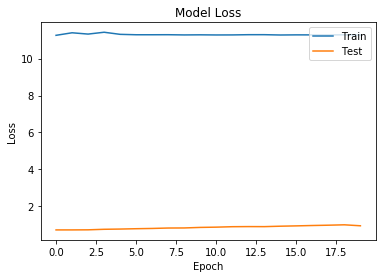

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

This model is underfit, evidenced by the high test loss that doesn't converge. More training data might solve this problem. Because of the underfitting, the model will likely not output good results.

In [26]:
filename = "model_weights_saved.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Now to test the model. I input the beginning of a cover letter. The loop deletes the first token in the sample, predicts on a sequence of the specified length, append the predicted word to the end of the sample. The first word is dropped and the model predicts on the next sequence. 

In [27]:
sample = "I am excited to apply for your company because I"
sample = sample.lower()
sample_split = word_tokenize(sample)
sample_split.insert(0, 0)

for i in range(25):
    sample_split = sample_split[1:]

    sample_ids = [word_to_id[word] for word in sample_split]

    sample_array = tf.convert_to_tensor(sample_ids)
    sample_array = [list(sample_array)]
    sample_array = np.reshape(sample_array, (1, seq_len, 1))
    prediction = model.predict(sample_array)


    pred_index = prediction[0].argmax()
    new_word = tokens_list[pred_index]
    sample_split.append(new_word)
    sample = sample + ' ' + new_word

sample = sample.capitalize()
print(sample)

I am excited to apply for your company because i the the the the the the the the the the the the the the the the the the the the the the the the the


# Model 2

In [28]:
model_2 = Sequential()
model_2.add(LSTM(256, input_shape=(X_array.shape[1], X_array.shape[2]), return_sequences=True))
model_2.add(Dense(256, activation = 'relu'))
model_2.add(LSTM(128, return_sequences = True))
model_2.add(Dense(128, activation = 'relu'))
model_2.add(LSTM(256, return_sequences = True))
model_2.add(Dense(y_array.shape[1], activation='softmax'))

In [29]:
history_2 = model.fit(X_array, y_array, validation_split = 0.2, epochs=20, batch_size=256, callbacks=desired_callbacks)

Epoch 1/20
42/42 [==============================] - 27s 519ms/step - loss: 13.0437 - val_loss: 0.7456

Epoch 00001: loss did not improve from 11.25634
Epoch 2/20
42/42 [==============================] - 19s 453ms/step - loss: 10.3689 - val_loss: 0.7231

Epoch 00002: loss did not improve from 11.25634
Epoch 3/20
42/42 [==============================] - 19s 451ms/step - loss: 9.4916 - val_loss: 0.7606

Epoch 00003: loss did not improve from 11.25634
Epoch 4/20
42/42 [==============================] - 19s 454ms/step - loss: 10.1956 - val_loss: 0.7826

Epoch 00004: loss did not improve from 11.25634
Epoch 5/20
42/42 [==============================] - 19s 465ms/step - loss: 12.3464 - val_loss: 0.8046

Epoch 00005: loss did not improve from 11.25634
Epoch 6/20
42/42 [==============================] - 19s 452ms/step - loss: 11.0861 - val_loss: 0.8408

Epoch 00006: loss did not improve from 11.25634
Epoch 7/20
42/42 [==============================] - 19s 454ms/step - loss: 11.9074 - val_loss: 

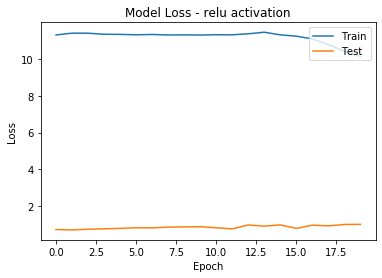

In [30]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss - relu activation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [31]:
sample = "I am excited to apply for your company because I"
sample = sample.lower()
sample_split = word_tokenize(sample)
sample_split.insert(0, 0)

for i in range(25):
    sample_split = sample_split[1:]

    sample_ids = [word_to_id[word] for word in sample_split]

    sample_array = tf.convert_to_tensor(sample_ids)
    sample_array = [list(sample_array)]
    sample_array = np.reshape(sample_array, (1, seq_len, 1))
    prediction = model.predict(sample_array)


    pred_index = prediction[0].argmax()
    new_word = tokens_list[pred_index]
    sample_split.append(new_word)
    sample = sample + ' ' + new_word

sample = sample.capitalize()
print(sample)

I am excited to apply for your company because i my i research learning disputes small building interpersonal in career the including including career remarks remarks remarks remarks remarks remarks remarks remarks remarks remarks remarks


The output of both of these models is English text, but it does not make sense. The first model simply predicts the word that appears immediately before it. The loss of the second model doesn't seem improve until about the 12th epoch. Since both models have an underfitting problem, the results could probably be improved by more training data. Neural nets require large training sets, and my corpus only contains 51 cover letter samples.